Recupero dati di disoccupazione (UNEMPLOYMENT) da Alpha Vantage...
Dati recuperati. Esempio di righe:
             value
date             
1948-01-01    3.4
1948-02-01    3.8
1948-03-01    4.0
1948-04-01    3.9
1948-05-01    3.5 

Dimensione DataFrame: (925, 1)
Feature engineering completato. Esempio:

            Unemployment  Lag_1  Lag_2  Lag_3  Diff_1      MA_3  Target
date                                                                   
1948-04-01           3.9    4.0    3.8    3.4    -0.1  3.900000     3.5
1948-05-01           3.5    3.9    4.0    3.8    -0.4  3.800000     3.6
1948-06-01           3.6    3.5    3.9    4.0     0.1  3.666667     3.6
1948-07-01           3.6    3.6    3.5    3.9     0.0  3.566667     3.9
1948-08-01           3.9    3.6    3.6    3.5     0.3  3.700000     3.8

Dimensione Training Set: (736, 5) Dimensione Test Set: (185, 5)

=== Linear Regression ===
MSE: 0.808707, R²: 0.8450

=== Ridge Regression ===
Miglior parametro alpha: {'alpha': 0.001}
MSE: 0

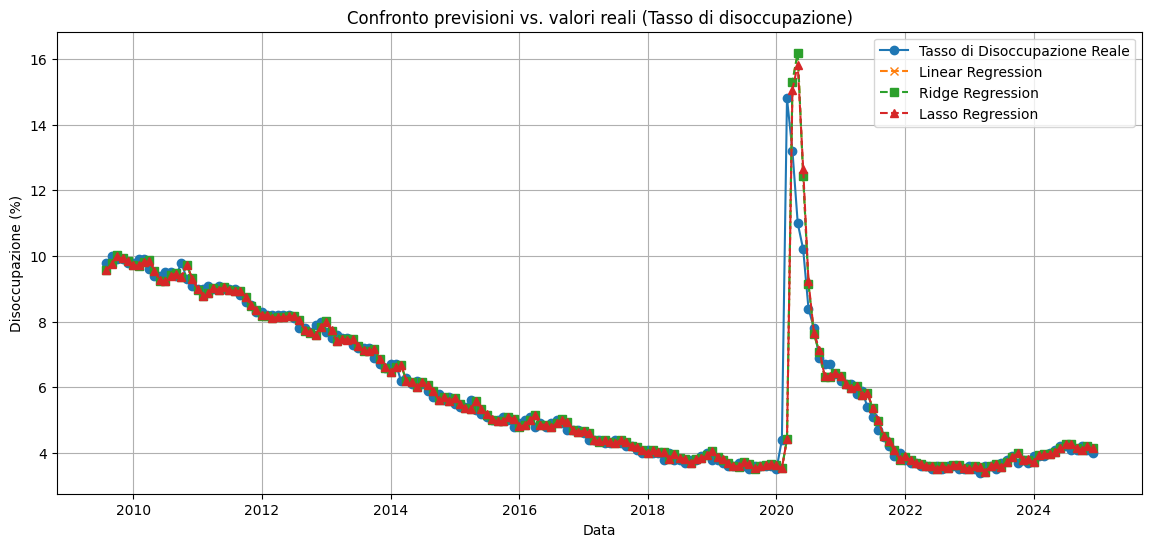


Coefficienti Linear Regression:
 Lag_1     0.808174
Lag_2    -0.321484
Lag_3    -0.198142
Diff_1    0.792035
MA_3      0.695633
dtype: float64

Coefficienti Ridge Regression:
 Lag_1     0.808148
Lag_2    -0.321434
Lag_3    -0.198158
Diff_1    0.792013
MA_3      0.695625
dtype: float64

Coefficienti Lasso Regression:
 Lag_1     1.233085
Lag_2    -0.039839
Lag_3    -0.209216
Diff_1    1.003848
MA_3      0.000000
dtype: float64

=== Riepilogo metriche ===
Linear Regression -> MSE: 0.808707, R²: 0.8450
Ridge Regression  -> MSE: 0.808693, R²: 0.8450
Lasso Regression  -> MSE: 0.791420, R²: 0.8483

Qui stiamo cercando di prevedere la disoccupazione del mese successivo
a partire dalle serie storiche passate (lag, differenze, medie mobili).
È un compito non banale, perché i dati macroeconomici mensili hanno
dinamiche più lente e possono dipendere da molti altri fattori esterni.

Osserva:
- Il MSE e l'R² (che può anche essere basso o negativo) ti dicono
  quanto il modello spiega la variabilità

In [ ]:
# =============================================================================
# Esempio: Regressioni (Linear, Ridge, Lasso) su dati di disoccupazione (UNEMPLOYMENT)
# =============================================================================
#
# In questo script:
# 1. Recuperiamo i dati di disoccupazione USA (mensili) da Alpha Vantage.
# 2. Effettuiamo del feature engineering (lag, differenze, medie mobili).
# 3. Creiamo un modello baseline di Regressione Lineare e poi confrontiamo
#    con Ridge e Lasso, cercando di prevedere la disoccupazione del mese successivo.
# 4. Confrontiamo MSE e R², e mostriamo i coefficienti.
#
# =============================================================================

import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import datetime

# -----------------------------
# 1. Parametri e Funzioni
# -----------------------------
API_KEY = "003LNB7GX6QL9TY2"  # Inserisci la tua API Key

# Endpoint per scaricare i dati di disoccupazione (mensili)
url = f"https://www.alphavantage.co/query?function=UNEMPLOYMENT&apikey={API_KEY}"

# -----------------------------
# 2. Download e Preparazione Dati
# -----------------------------
print("Recupero dati di disoccupazione (UNEMPLOYMENT) da Alpha Vantage...")
response = requests.get(url)
if response.status_code != 200:
    raise Exception("Errore nella chiamata API. Controlla la connessione o la chiave API.")

data = response.json()

# La struttura dei dati è simile a: {"name": "...", "interval": "monthly", "data": [...]}
if "data" not in data:
    raise Exception("Struttura dati inaspettata. 'data' non presente nella risposta.")

# Creiamo un DataFrame
df = pd.DataFrame(data["data"])
# Ogni entry in 'data' contiene: { "date": "YYYY-MM-DD", "value": "X.YZ" }

# Convertiamo la colonna 'date' a datetime e ordiniamo
df['date'] = pd.to_datetime(df['date'])
df['value'] = df['value'].astype(float)  # tasso di disoccupazione
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

print("Dati recuperati. Esempio di righe:\n", df.head(), "\n")
print("Dimensione DataFrame:", df.shape)

# -----------------------------
# 3. Feature Engineering
# -----------------------------
# Rinominiamo la colonna 'value' in 'Unemployment' per chiarezza
df.rename(columns={'value': 'Unemployment'}, inplace=True)

# Creiamo alcune feature di esempio:
# 1) Lag del tasso di disoccupazione (1, 2, 3 mesi prima)
df['Lag_1'] = df['Unemployment'].shift(1)
df['Lag_2'] = df['Unemployment'].shift(2)
df['Lag_3'] = df['Unemployment'].shift(3)

# 2) Differenza mensile: come cambia la disoccupazione rispetto al mese precedente
df['Diff_1'] = df['Unemployment'].diff(1)

# 3) Media mobile a 3 mesi
df['MA_3'] = df['Unemployment'].rolling(window=3).mean()

# Rimuoviamo eventuali righe con NaN generate dalle funzioni shift/rolling
df.dropna(inplace=True)

# Target: vogliamo prevedere la disoccupazione del mese successivo
# Quindi shift di -1 sulla colonna 'Unemployment'
df['Target'] = df['Unemployment'].shift(-1)
df.dropna(inplace=True)  # Rimuoviamo l'ultima riga che diventa NaN

print("Feature engineering completato. Esempio:\n")
print(df[['Unemployment', 'Lag_1', 'Lag_2', 'Lag_3', 'Diff_1', 'MA_3', 'Target']].head())

# -----------------------------
# 4. Selezione Feature e Split
# -----------------------------
feature_cols = ['Lag_1', 'Lag_2', 'Lag_3', 'Diff_1', 'MA_3']
X = df[feature_cols]
y = df['Target']

# Suddividiamo i dati in training e test (80% - 20%), mantenendo l'ordine temporale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("\nDimensione Training Set:", X_train.shape, "Dimensione Test Set:", X_test.shape)

# -----------------------------
# 5. Baseline: Linear Regression
# -----------------------------
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)

print("\n=== Linear Regression ===")
print(f"MSE: {lr_mse:.6f}, R²: {lr_r2:.4f}")

# -----------------------------
# 6. Ridge Regression
# -----------------------------
alpha_values = {'alpha': np.logspace(-3, 3, 20)}
ridge = Ridge()

ridge_cv = GridSearchCV(
    estimator=ridge,
    param_grid=alpha_values,
    cv=5,
    scoring='neg_mean_squared_error'
)
ridge_cv.fit(X_train, y_train)

ridge_pred = ridge_cv.predict(X_test)
ridge_mse = mean_squared_error(y_test, ridge_pred)
ridge_r2 = r2_score(y_test, ridge_pred)

print("\n=== Ridge Regression ===")
print("Miglior parametro alpha:", ridge_cv.best_params_)
print(f"MSE: {ridge_mse:.6f}, R²: {ridge_r2:.4f}")

# -----------------------------
# 7. Lasso Regression
# -----------------------------
lasso = Lasso(max_iter=10000)
lasso_cv = GridSearchCV(
    estimator=lasso,
    param_grid=alpha_values,
    cv=5,
    scoring='neg_mean_squared_error'
)
lasso_cv.fit(X_train, y_train)

lasso_pred = lasso_cv.predict(X_test)
lasso_mse = mean_squared_error(y_test, lasso_pred)
lasso_r2 = r2_score(y_test, lasso_pred)

print("\n=== Lasso Regression ===")
print("Miglior parametro alpha:", lasso_cv.best_params_)
print(f"MSE: {lasso_mse:.6f}, R²: {lasso_r2:.4f}")

# -----------------------------
# 8. Visualizzazione
# -----------------------------
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, y_test, label='Tasso di Disoccupazione Reale', marker='o', linestyle='-')
plt.plot(y_test.index, lr_pred, label='Linear Regression', marker='x', linestyle='--')
plt.plot(y_test.index, ridge_pred, label='Ridge Regression', marker='s', linestyle='--')
plt.plot(y_test.index, lasso_pred, label='Lasso Regression', marker='^', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Disoccupazione (%)')
plt.title('Confronto previsioni vs. valori reali (Tasso di disoccupazione)')
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------
# 9. Coefficienti
# -----------------------------
lr_coefficients = pd.Series(lr_model.coef_, index=feature_cols)
ridge_coefficients = pd.Series(ridge_cv.best_estimator_.coef_, index=feature_cols)
lasso_coefficients = pd.Series(lasso_cv.best_estimator_.coef_, index=feature_cols)

print("\nCoefficienti Linear Regression:\n", lr_coefficients)
print("\nCoefficienti Ridge Regression:\n", ridge_coefficients)
print("\nCoefficienti Lasso Regression:\n", lasso_coefficients)

# -----------------------------
# 10. Conclusioni
# -----------------------------
print("\n=== Riepilogo metriche ===")
print(f"Linear Regression -> MSE: {lr_mse:.6f}, R²: {lr_r2:.4f}")
print(f"Ridge Regression  -> MSE: {ridge_mse:.6f}, R²: {ridge_r2:.4f}")
print(f"Lasso Regression  -> MSE: {lasso_mse:.6f}, R²: {lasso_r2:.4f}")

print("""
Qui stiamo cercando di prevedere la disoccupazione del mese successivo
a partire dalle serie storiche passate (lag, differenze, medie mobili).
È un compito non banale, perché i dati macroeconomici mensili hanno
dinamiche più lente e possono dipendere da molti altri fattori esterni.

Osserva:
- Il MSE e l'R² (che può anche essere basso o negativo) ti dicono
  quanto il modello spiega la variabilità della disoccupazione mensile futura.
- I coefficienti dei modelli (in particolare Lasso e Ridge) mostrano
  come la regolarizzazione agisce nel "contenere" o azzerare alcuni
  parametri, riducendo l'overfitting.
- Se l'R² risulta basso, è indice che il modello lineare (con queste poche feature)
  non è in grado di catturare bene la dinamica della disoccupazione.
  Potresti aggiungere altre variabili macro (es. PIL, inflazione, tassi di interesse, ecc.)
  per aumentare la capacità predittiva.
""")
